# Tutorial 6 - Managing simulation outputs

In the previous tutorials we have interacted with the outputs of the simulation via the default plotting functionality. However, usually we need to access the output data to manipulate it or transfer to another software, which is the topic of this notebook.

We start by building and solving our model as shown in previous notebooks:

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import matplotlib.pyplot as plt
import numpy as np

import pybamm

model = pybamm.lithium_ion.SPMe()
sim = pybamm.Simulation(model)
sim.solve([0, 3600])

Note: you may need to restart the kernel to use updated packages.


## Accessing solution variables

We can now access the solved variables directly to visualise or create our own plots. We first extract the solution object:

In [2]:
solution = sim.solution

Note that the solution object is also returned when calling the `solve` method, so this can be streamlined by running

In [3]:
solution = sim.solve([0, 3600])

when solving our simulation. Once we have the solution, we can define post-processed variable for the relevant variables:

In [4]:
t = solution["Time [s]"]
V = solution["Voltage [V]"]

(for a list of all the available variables see [Tutorial 3](./tutorial-3-basic-plotting.ipynb)). These `ProcessedVariable` objects contain the datapoints for the corresponding variable, which can be accessed by calling the `entries` variable. For example, for voltage, we can call

In [5]:
V.entries

array([3.77057396, 3.77055358, 3.77053333, 3.7704931 , 3.77041403,
       3.7702603 , 3.76997849, 3.76971335, 3.76923473, 3.76879676,
       3.76839135, 3.76763934, 3.76696517, 3.7657705 , 3.76482861,
       3.76396994, 3.76317298, 3.76242499, 3.76105167, 3.75980242,
       3.75865012, 3.75758225, 3.75659013, 3.75479647, 3.7532074 ,
       3.75177811, 3.75047724, 3.74928148, 3.74817179, 3.74713337,
       3.74522275, 3.74364749, 3.74187167, 3.74036101, 3.73891052,
       3.73750368, 3.73613075, 3.73478468, 3.73346097, 3.73086618,
       3.7283324 , 3.72584895, 3.7210167 , 3.71687343, 3.7128573 ,
       3.70897172, 3.70521899, 3.70159986, 3.69476089, 3.68844401,
       3.68262899, 3.67728754, 3.6723848 , 3.66372342, 3.65617236,
       3.63840595, 3.59767151, 3.48863759, 3.17213165])

which correspond to the data at the times

In [6]:
t.entries

array([0.00000000e+00, 1.23792596e-02, 2.47585193e-02, 4.95170385e-02,
       9.90340771e-02, 1.98068154e-01, 3.96136308e-01, 5.94204462e-01,
       9.90340771e-01, 1.38647708e+00, 1.78261339e+00, 2.57488600e+00,
       3.36715862e+00, 4.95170385e+00, 6.37779456e+00, 7.80388527e+00,
       9.22997598e+00, 1.06560667e+01, 1.35082481e+01, 1.63604295e+01,
       1.92126109e+01, 2.20647924e+01, 2.49169738e+01, 3.06213366e+01,
       3.63256995e+01, 4.20300623e+01, 4.77344251e+01, 5.34387880e+01,
       5.91431508e+01, 6.48475137e+01, 7.62562393e+01, 8.65240924e+01,
       9.89736408e+01, 1.10178234e+02, 1.21382828e+02, 1.32587421e+02,
       1.43792015e+02, 1.54996608e+02, 1.66201202e+02, 1.88610389e+02,
       2.11019576e+02, 2.33428763e+02, 2.78247137e+02, 3.17930983e+02,
       3.57614829e+02, 3.97298675e+02, 4.36982521e+02, 4.76666368e+02,
       5.56034060e+02, 6.35401752e+02, 7.14769445e+02, 7.94137137e+02,
       8.73504829e+02, 1.03224021e+03, 1.19097560e+03, 1.50844637e+03,
      

In addition, post-processed variables can be called at any time, which will return the interpolated value from the data above:

In [7]:
V([200, 400, 780, 1236])  # times in seconds

array([3.72957107, 3.70871203, 3.67820577, 3.65411564])

## Observing custom variables from the solution

The `model.variables` dictionary contains many common simulation outputs, such as

In [8]:
model.variables

{'Time [s]': Time(0x7acf79e701953ff1, time, children=[], domains={}),
 'Time [min]': Multiplication(-0x6825f269d15d39e2, *, children=['0.016666666666666666', 'time'], domains={}),
 'Time [h]': Multiplication(0x48e47d91ee07de8b, *, children=['0.0002777777777777778', 'time'], domains={}),
 'x [m]': SpatialVariable(-0x74754c4b7b68d93d, x, children=[], domains={'primary': ['negative electrode', 'separator', 'positive electrode'], 'secondary': ['current collector']}),
 'x_n [m]': SpatialVariable(0x4430ee86444c9f0d, x_n, children=[], domains={'primary': ['negative electrode'], 'secondary': ['current collector']}),
 'x_s [m]': SpatialVariable(0x21fc788358b5d6c9, x_s, children=[], domains={'primary': ['separator'], 'secondary': ['current collector']}),
 'x_p [m]': SpatialVariable(-0x4680fdfc015239c8, x_p, children=[], domains={'primary': ['positive electrode'], 'secondary': ['current collector']}),
 'r_n [m]': SpatialVariable(0x710d0fceaf05982f, r_n, children=[], domains={'primary': ['negative

Even if a variable has not been included in the built `pybamm.Simulation`, it can still be output if the model contains the necessary building blocks. For example, we can calculate conductance from `"Current [A]"` and `"Voltage [V]"` in the `model.variables`,
$$
G = \dfrac{I}{V} ,
$$
which produces a standard `ProcessedVariable` object.

In [27]:
conductance_symbol = model.variables["Current [A]"] / model.variables["Voltage [V]"]
conductance = solution.observe(conductance_symbol)
conductance

Text(0, 0.5, 'Conductance [S]')

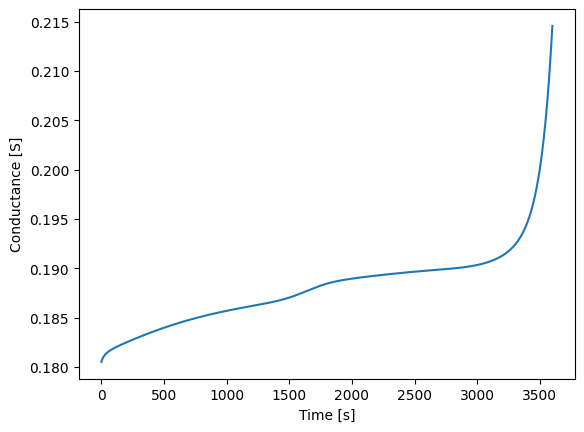

In [25]:
# Interpolate the solution
t = np.linspace(0, solution.t[-1], 1000)

plt.plot(t, conductance(t))
plt.xlabel("Time [s]")
plt.ylabel("Conductance [S]")

## Saving the simulation and output data

In some cases simulations might take a long time to run so it is advisable to save in your computer so it can be analysed later without re-running the simulation. You can save the whole simulation doing:

In [10]:
sim.save("SPMe.pkl")

If you now check the root directory of your notebooks you will notice that a new file called `"SPMe.pkl"` has appeared. We can load the stored simulation doing

In [11]:
sim2 = pybamm.load("SPMe.pkl")

which allows the same manipulation as the original simulation would allow

In [12]:
sim2.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

Alternatively, we can just save the solution of the simulation in a similar way

In [13]:
sol = sim.solution
sol.save("SPMe_sol.pkl")

and load it in a similar way too

In [14]:
sol2 = pybamm.load("SPMe_sol.pkl")
sol2.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

Another option is to just save the data for some variables

In [15]:
sol.save_data("sol_data.pkl", ["Current [A]", "Voltage [V]"])

or save it in `.csv` or `.mat` format

In [16]:
sol.save_data("sol_data.csv", ["Current [A]", "Voltage [V]"], to_format="csv")
# matlab needs names without spaces
sol.save_data(
    "sol_data.mat",
    ["Current [A]", "Voltage [V]"],
    to_format="matlab",
    short_names={"Current [A]": "I", "Voltage [V]": "V"},
)

Note that while exporting `.pkl` works for all variables, exporting to `.csv` and `.mat` only works for 0D variables (i.e. variables the do not depend on space, only on time).

In this notebook we have shown how to extract and store the outputs of PyBaMM's simulations. Next, in [Tutorial 7](./tutorial-7-model-options.ipynb) we will show how to change the model options.

Before finishing we will remove the data files we saved so that we leave the directory as we found it

In [17]:
import os

os.remove("SPMe.pkl")
os.remove("SPMe_sol.pkl")
os.remove("sol_data.pkl")
os.remove("sol_data.csv")
os.remove("sol_data.mat")

## References

The relevant papers for this notebook are:

In [18]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[3] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[4] Alan C. Hindmarsh. The PVODE and IDA algorithms. Technical Report, Lawrence Livermore National Lab., CA (US), 2000. doi:10.2172/802599.
[5] Alan C. Hindmarsh, Peter N. Brown, Keith E. Grant, Steven L. Lee, Radu Serban, Dan E